## Introduction:

> Kickstarter is an American public-benefit corporation[2] based in Brooklyn, New York, that maintains a global crowdfunding platform focused on creativity and merchandising.[3] The company's stated mission is to "help bring creative projects to life".[4] Kickstarter has reportedly received more than $1.9 billion in pledges from 9.4 million backers to fund 257,000 creative projects, such as films, music, stage shows, comics, journalism, video games, technology and food-related projects.[5]
People who back Kickstarter projects are offered tangible rewards or experiences in exchange for their pledges.[6] This model traces its roots to subscription model of arts patronage, where artists would go directly to their audiences to fund their work.[7][Wikipedia](https://en.wikipedia.org/wiki/Kickstarter)

So, with the help of the crawlers of [webrobots](https://webrobots.io/kickstarter-datasets/), we got all the data from the run along 2017 kickstater projects and keep just those written in english and finished either as "successful" or "failed", and two columns:

- the one with the blurb or short description of the project [text]
- the one with the final state: "successful" if the project got the money goal in time or "failed" if don't [factor]



## Getting and preprocessing data:

In [3]:
import pandas as pd
import numpy as np
data = pd.read_csv("data.csv")
data.head()

,Unnamed: 0,blurb,state
0,1,"Using their own character, users go on educati...",failed
1,2,"MicroFly is a quadcopter packed with WiFi, 6 s...",successful
2,3,"A small indie press, run as a collective for a...",failed
3,4,Zylor is a new baby cosplayer! Back this kicks...,failed
4,5,Hatoful Boyfriend meet Skeletons! A comedy Dat...,failed


Here we organize the dataframe more and make colum for mapping the {'successful':1,'failed':0}

In [4]:
del data['Unnamed: 0'] 
from io import StringIO
data['state_id'] = data['state'].factorize()[0]
state_id_df = data[['state', 'state_id']].drop_duplicates().sort_values('state_id')
state_to_id = dict(state_id_df.values)
id_to_state = dict(state_id_df[['state_id', 'state']].values)
data.head()

,blurb,state,state_id
0,"Using their own character, users go on educati...",failed,0
1,"MicroFly is a quadcopter packed with WiFi, 6 s...",successful,1
2,"A small indie press, run as a collective for a...",failed,0
3,Zylor is a new baby cosplayer! Back this kicks...,failed,0
4,Hatoful Boyfriend meet Skeletons! A comedy Dat...,failed,0


I want to check if there is impalanced class 

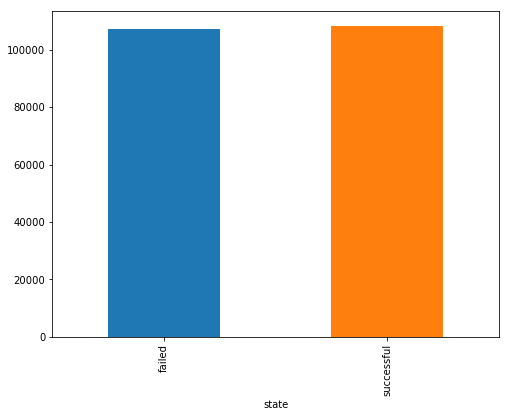

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
data.groupby('state').blurb.count().plot.bar(ylim=0)
plt.show()

seems that there is no problem here

Now lets clean the text for training , i see no need to delete the stopwords so i will just remove punctuations

In [6]:
import re
def clean(text):
    text = str(text)
    text = re.findall(r'\w+', text)
    return ' '.join(text)
data['blurb'] = data['blurb'].apply(lambda x: clean(x))

## Text Representation

Now for text representation i will use tfidf model

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
x_train, x_test, y_train, y_test = train_test_split(data['blurb'], data['state'], train_size=0.8)
vectorizer = TfidfVectorizer().fit(x_train)
x_train_v = vectorizer.transform(x_train)
x_test_v  = vectorizer.transform(x_test)

/home/mogady/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Training 

I will try multiple algorthims and see what gives better accuracy

In [8]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from time import time
entries = []
def train():
    models = {
        "LogisticRegression": LogisticRegression(),
        "SGDClassifier": SGDClassifier(),
        "Multinomial":MultinomialNB(),
        "LinearSVC": LinearSVC(),
    }
    for model in models:
        print("training model"+model)
        start = time()
        models[model].fit(x_train_v, y_train)
        end = time()
        print("trained in {} secs".format(end-start))
        y_pred = models[model].predict(x_test_v)
        entries.append((model,accuracy_score(y_test, y_pred)))

In [9]:
train()

training modelLogisticRegression
trained in 2.3976640701293945 secs
training modelSGDClassifier


/home/mogady/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


trained in 0.3780059814453125 secs
training modelMultinomial
trained in 0.5360188484191895 secs
training modelLinearSVC
trained in 3.069472074508667 secs


#### lets Visualize the accuracies

/home/mogady/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


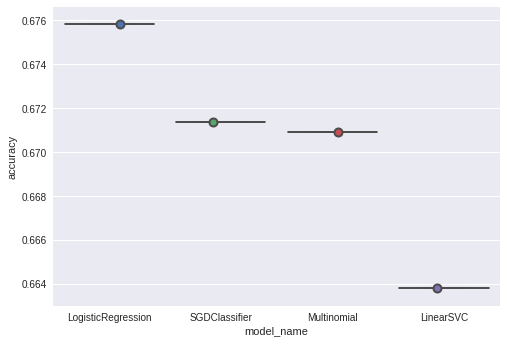

In [10]:
cv_df = pd.DataFrame(entries, columns=['model_name','accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

Ok,it seems that LogisticRegression did the job.

## Evaluation:
now lets look at the confusion matrix, and show the discrepancies between predicted and actual labels.

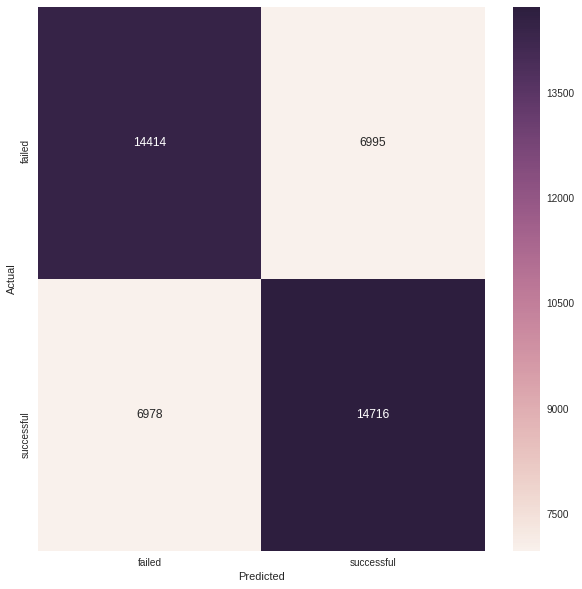

In [11]:
model = LogisticRegression()
model.fit(x_train_v, y_train)
y_pred = model.predict(x_test_v)
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=state_id_df.state.values, yticklabels=state_id_df.state.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [12]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

     failed       0.67      0.67      0.67     21409
 successful       0.68      0.68      0.68     21694

avg / total       0.68      0.68      0.68     43103

